In [5]:
!pip install -qU \
    google-cloud-aiplatform \
    google-cloud-storage \
    llama-index \
    llama-index-embeddings-vertex \
    llama-index-llms-vertex \
    llama-index-vector_stores-vertexaivectorsearch \
    llama-index-llms-fireworks


In [6]:
from llama_index.llms.vertex import Vertex

In [7]:
PROJECT_ID = "angelic-bee-193823"  
LOCATION = "us-central1"  

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [8]:
# Imports
import os

from google.cloud import aiplatform, storage
from llama_index.core import (
    Document,
    PromptTemplate,
    Settings,
    SimpleDirectoryReader,
    StorageContext,
    SummaryIndex,
    VectorStoreIndex,
)
from llama_index.core.agent import ReActAgent
from llama_index.core.base.base_query_engine import BaseQueryEngine
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.objects import ObjectIndex
from llama_index.core.prompts import LangchainPromptTemplate
from llama_index.core.prompts.base import BasePromptTemplate
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.embeddings.vertex import VertexTextEmbedding
from llama_index.llms.vertex import Vertex
from llama_index.vector_stores.vertexaivectorsearch import VertexAIVectorStore

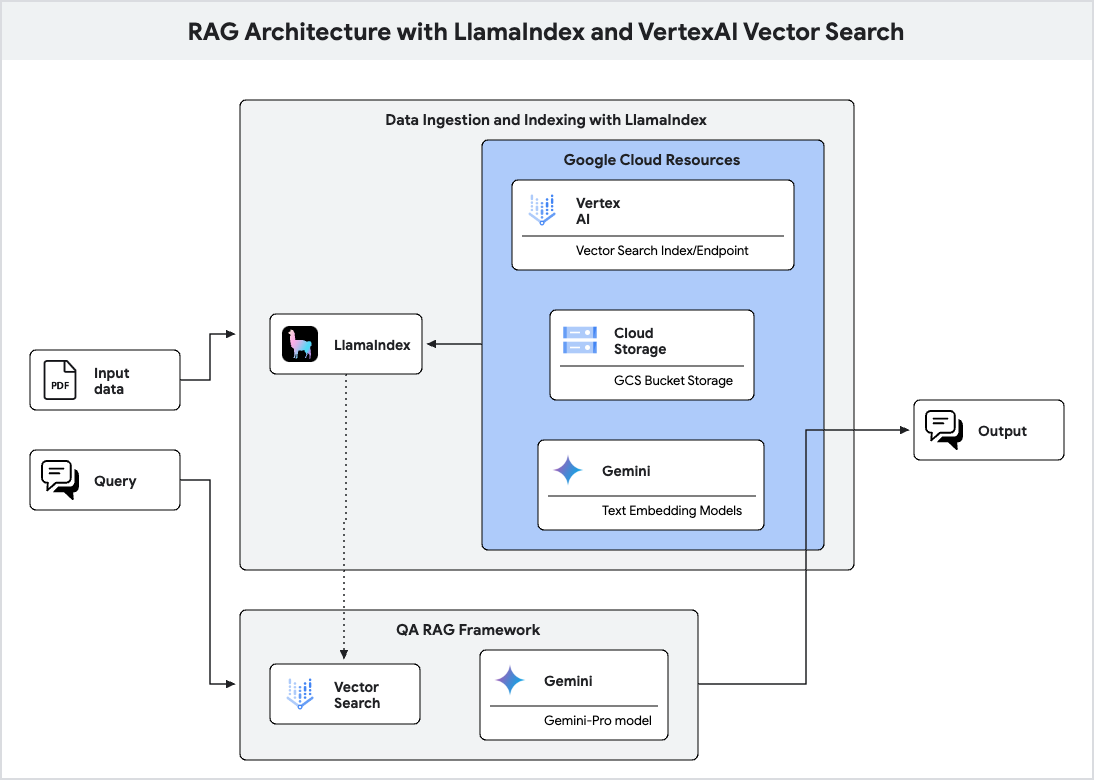

## Define Function Tool to Fetch Input Data

In [11]:
import requests
import json
import logging
from bs4 import BeautifulSoup
from typing import Dict, List, Optional
from dataclasses import dataclass, asdict
from IPython.display import JSON, display
from rich.console import Console
from rich.panel import Panel

@dataclass
class DevFestSession:
    """Data class for storing session information"""
    title: str
    speaker: str
    time: str
    track: str
    day: str
    room: str
    session_type: str
    description: str = "Not provided"
    tags: List[str] = None

    def __post_init__(self):
        self.tags = self.tags or []

    def to_dict(self) -> Dict:
        return asdict(self)

class DevFestScraper:
    def __init__(self):
        self.logger = self._setup_logger()
        self.base_url = "https://devfestlagos.com"
        self.schedule_url = f"{self.base_url}/schedule"
        self.session = self._setup_session()
        self.console = Console()

    def _setup_logger(self) -> logging.Logger:
        logger = logging.getLogger('DevFestScraper')
        logger.setLevel(logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        return logger

    def _setup_session(self) -> requests.Session:
        session = requests.Session()
        session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        })
        return session

    def _get_html_content(self) -> Optional[str]:
        try:
            response = self.session.get(self.schedule_url)
            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            self.logger.error(f"Error fetching schedule page: {str(e)}")
            return None

    def _extract_session_data(self, event_element, day: str, session_type: str = "General") -> Optional[DevFestSession]:
        try:
            # Extract title
            if session_type == "General":
                title = event_element.find('h3').text.strip()
                time_elem = event_element.find('div', class_='EventBlock_time__RQGQz')
                time = time_elem.text.strip() if time_elem else "Time not specified"
                venue_elem = event_element.find('div', class_='EventBlock_venue__wjpVu')
                room = venue_elem.find('span').text.strip() if venue_elem and venue_elem.find('span') else "Main Hall"
                speaker = "N/A"
            else:
                title_elem = event_element.find('h3', class_='EventCategory_eventSchedule__event-title__F2air')
                title = title_elem.text.strip() if title_elem else "No Title"
                speaker_elem = event_element.find('p', class_='EventCategory_eventSchedule__event-facilitator__nWvuU')
                speaker = speaker_elem.text.strip() if speaker_elem else "Not specified"
                time_elem = event_element.find('div', class_='EventCategory_eventSchedule__event-time__f_zfq')
                time = time_elem.find('span', class_='text-sm').text.strip() if time_elem else "Time not specified"
                room = "Breakout Room"

            track = "General" if session_type == "General" else room

            return DevFestSession(
                title=title,
                speaker=speaker,
                time=time,
                track=track,
                day=day,
                room=room,
                session_type=session_type
            )
        except Exception as e:
            self.logger.error(f"Error extracting session data: {str(e)}")
            return None

    def scrape_schedule(self) -> Dict[str, List[Dict]]:
        schedule = {
            'day1': [],
            'day2': []
        }

        html_content = self._get_html_content()
        if not html_content:
            return schedule

        soup = BeautifulSoup(html_content, 'html.parser')
        schedule_container = soup.find('div', class_='schedule_scheduleItemsContainer__wkWNt')
        
        if not schedule_container:
            self.logger.error("Could not find schedule container")
            return schedule

        # Get all general sessions
        general_events = schedule_container.find_all('div', class_='EventBlock_event__UsJua')
        for event in general_events:
            session = self._extract_session_data(event, "Day 1", "General")
            if session:
                schedule['day1'].append(session.to_dict())

        # Get all breakout sessions
        breakout_container = schedule_container.find('div', class_='EventCategory_eventSchedule__events__cCu22')
        if breakout_container:
            breakout_events = breakout_container.find_all('div', class_='EventCategory_eventSchedule__event__AhbY3')
            for event in breakout_events:
                session = self._extract_session_data(event, "Day 1", "Breakout")
                if session:
                    schedule['day1'].append(session.to_dict())

        return schedule

    def display_summary(self, schedule: Dict[str, List[Dict]]):
        """Display summary of scraped sessions"""
        total_sessions = len(schedule['day1']) + len(schedule['day2'])
        summary = f"""
        📊 Scraping Summary:
        ----------------------
        Total sessions: {total_sessions}
        Day 1 sessions: {len(schedule['day1'])}
        Day 2 sessions: {len(schedule['day2'])}
        """
        self.console.print(Panel(summary, title="DevFest Schedule Scraper", border_style="green"))

# Run the scraper and display results
scraper = DevFestScraper()
print("Scraping DevFest Lagos schedule...")
schedule = scraper.scrape_schedule()

# Display summary
scraper.display_summary(schedule)

# Save to JSON file
with open('devfest_schedule.json', 'w', encoding='utf-8') as f:
    json.dump(schedule, f, ensure_ascii=False, indent=2)

# Display the JSON data in notebook
data = JSON(schedule)
display(data)


Scraping DevFest Lagos schedule...


╭─────────────────────────────────────────── DevFest Schedule Scraper ────────────────────────────────────────────╮
│                                                                                                                 │
│         📊 Scraping Summary:                                                                                    │
│         ----------------------                                                                                  │
│         Total sessions: 18                                                                                      │
│         Day 1 sessions: 18                                                                                      │
│         Day 2 sessions: 0                                                                                       │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

<IPython.core.display.JSON object>

In [13]:
data

<IPython.core.display.JSON object>

In [18]:
from typing import Dict, List
from llama_index.core.tools import FunctionTool
import requests
import json
from bs4 import BeautifulSoup

def get_devfest_schedule() -> Dict[str, List[Dict]]:
    """
    Scrape and return the DevFest Lagos schedule as JSON data.
    Returns a dictionary with days as keys and lists of session information as values.
    
    Example output:
    {
        "day1": [
            {
                "title": "Opening Keynote",
                "speaker": "John Doe",
                "time": "9:00 AM",
                "track": "General",
                "room": "Main Hall",
                "session_type": "General"
            },
            ...
        ],
        "day2": [...]
    }
    """
    # Initialize schedule structure
    schedule = {
        'day1': [],
        'day2': []
    }
    
    try:
        # Set up session and get page content
        session = requests.Session()
        session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        })
        
        # Get HTML content
        response = session.get("https://devfestlagos.com/schedule")
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find schedule container
        schedule_container = soup.find('div', class_='schedule_scheduleItemsContainer__wkWNt')
        
        if schedule_container:
            # Extract general sessions
            general_events = schedule_container.find_all('div', class_='EventBlock_event__UsJua')
            for event in general_events:
                session_data = {
                    'title': event.find('h3').text.strip(),
                    'time': event.find('div', class_='EventBlock_time__RQGQz').text.strip() if event.find('div', class_='EventBlock_time__RQGQz') else "Time not specified",
                    'room': event.find('div', class_='EventBlock_venue__wjpVu').find('span').text.strip() if event.find('div', class_='EventBlock_venue__wjpVu') and event.find('div', class_='EventBlock_venue__wjpVu').find('span') else "Main Hall",
                    'speaker': "N/A",
                    'track': "General",
                    'session_type': "General",
                    'day': "Day 1"
                }
                schedule['day1'].append(session_data)
            
            # Extract breakout sessions
            breakout_container = schedule_container.find('div', class_='EventCategory_eventSchedule__events__cCu22')
            if breakout_container:
                breakout_events = breakout_container.find_all('div', class_='EventCategory_eventSchedule__event__AhbY3')
                for event in breakout_events:
                    session_data = {
                        'title': event.find('h3', class_='EventCategory_eventSchedule__event-title__F2air').text.strip() if event.find('h3', class_='EventCategory_eventSchedule__event-title__F2air') else "No Title",
                        'speaker': event.find('p', class_='EventCategory_eventSchedule__event-facilitator__nWvuU').text.strip() if event.find('p', class_='EventCategory_eventSchedule__event-facilitator__nWvuU') else "Not specified",
                        'time': event.find('div', class_='EventCategory_eventSchedule__event-time__f_zfq').find('span', class_='text-sm').text.strip() if event.find('div', class_='EventCategory_eventSchedule__event-time__f_zfq') else "Time not specified",
                        'room': "Breakout Room",
                        'track': "Breakout",
                        'session_type': "Breakout",
                        'day': "Day 1"
                    }
                    schedule['day1'].append(session_data)
    
    except Exception as e:
        print(f"Error scraping schedule: {str(e)}")
        
    return schedule

# Create the Llama Index Function Tool
devfest_schedule_tool = FunctionTool.from_defaults(
    fn=get_devfest_schedule,
    name="get_devfest_schedule",
    description="Get the complete DevFest Lagos schedule as JSON data"
)


In [19]:
# Example usage in Jupyter notebook
if __name__ == "__main__":
    # Get the schedule
    schedule_data = get_devfest_schedule()
    
    # Display as JSON in notebook
    from IPython.display import JSON, display
    display(JSON(schedule_data))
    
    # Save to file
    with open('devfest_schedule.json', 'w', encoding='utf-8') as f:
        json.dump(schedule_data, f, ensure_ascii=False, indent=2)

<IPython.core.display.JSON object>

In [23]:
from typing import Dict, List
from llama_index.core import (
    Document,
    PromptTemplate,
    Settings,
    SimpleDirectoryReader,
    StorageContext,
    SummaryIndex,
    VectorStoreIndex,
)

from llama_index.embeddings.vertex import VertexTextEmbedding
from llama_index.llms.vertex import Vertex
from llama_index.response_synthesizers import get_response_synthesizer

def convert_schedule_to_documents(schedule_data: Dict[str, List[Dict]]) -> List[Document]:
    """
    Convert schedule JSON data into Llama Index documents
    """
    documents = []
    
    for day, sessions in schedule_data.items():
        for session in sessions:
            # Create structured content
            content = f"""
            Session: {session['title']}
            Speaker: {session['speaker']}
            Time: {session['time']}
            Track: {session['track']}
            Room: {session['room']}
            Type: {session['session_type']}
            Day: {session['day']}
            """
            
            # Create metadata
            metadata = {
                "day": session['day'],
                "track": session['track'],
                "session_type": session['session_type'],
                "speaker": session['speaker']
            }
            
            # Create document
            doc = Document(
                text=content,
                metadata=metadata
            )
            documents.append(doc)
    
    return documents

def setup_custom_prompts():
    """
    Setup custom prompts for different querying options
    """
    # Basic RAG prompt
    basic_rag_template = PromptTemplate(
        """You are an AI assistant helping with DevFest Lagos conference schedule queries.
        Context information is below.
        ---------------------
        {context_str}
        ---------------------
        Given this information, please answer the question: {query_str}
        """
    )
    
    # Few-shot prompt with examples
    few_shot_template = PromptTemplate(
        """You are an AI assistant helping with DevFest Lagos conference schedule queries.
        Here are some example queries and responses:
        
        Question: When is the opening keynote?
        Answer: The opening keynote starts at [time] in the Main Hall.
        
        Question: What sessions are available for AI/ML track?
        Answer: Here are the AI/ML track sessions: [list sessions with times]
        
        Context information is below.
        ---------------------
        {context_str}
        ---------------------
        Given this information, please answer the question: {query_str}
        """
    )
    
    return {
        "basic_rag": basic_rag_template,
        "few_shot": few_shot_template
    }

def index_and_query_schedule(schedule_data: Dict[str, List[Dict]], storage_context: StorageContext):
    """
    Index the DevFest schedule data and set up query mechanisms
    """
    # Convert schedule to documents
    documents = convert_schedule_to_documents(schedule_data)
    
    # Initialize Gemini
    llm = Gemini()
    embed_model = GeminiEmbedding()
    
    # Create vector store index
    vector_index = VectorStoreIndex.from_documents(
        documents,
        storage_context=storage_context,
        llm=llm,
        embed_model=embed_model
    )
    
    # Set up prompts
    prompts = setup_custom_prompts()
    
    # Set up query engines with different prompts
    query_engines = {
        "default": vector_index.as_query_engine(),
        "basic_rag": vector_index.as_query_engine(
            text_qa_template=prompts["basic_rag"]
        ),
        "few_shot": vector_index.as_query_engine(
            text_qa_template=prompts["few_shot"]
        )
    }
    
    return query_engines

def query_schedule(query_engines: Dict, query: str):
    """
    Query the schedule using different prompting strategies
    """
    print("\n=== Default LlamaIndex Prompt ===")
    response = query_engines["default"].query(query)
    print(f"Response: {response}\n")
    
    print("=== Basic RAG Prompt ===")
    response = query_engines["basic_rag"].query(query)
    print(f"Response: {response}\n")
    
    print("=== Few-Shot Prompt ===")
    response = query_engines["few_shot"].query(query)
    print(f"Response: {response}\n")

# Example usage
if __name__ == "__main__":
    from llama_index.storage.storage_context import StorageContext
    
    # Get schedule data using our function tool
    schedule_data = get_devfest_schedule()
    
    # Create storage context
    storage_context = StorageContext.from_defaults()
    
    # Index the schedule
    query_engines = index_and_query_schedule(schedule_data, storage_context)
    
    # Example queries
    example_queries = [
        "What sessions are available on Day 1?",
        "Tell me about the AI/ML track sessions",
        "Who are the speakers in the Web Development track?",
        "What workshops are available in the afternoon?"
    ]
    
    # Run queries
    for query in example_queries:
        print(f"\n=== Query: {query} ===")
        query_schedule(query_engines, query)

ModuleNotFoundError: No module named 'llama_index.response_synthesizers'

In [ ]:
# def index_and_query_documents(
#     documents: list[Document], storage_context: StorageContext
# ):
#     """
#     Sets up vector store index to query against for a RAG pattern.
#     """
#     # Using Gemini embedding models
#     vector_index = VectorStoreIndex.from_documents(
#         documents, storage_context=storage_context
#     )

#     # Set up a query engine
#     query_engine = vector_index.as_query_engine()

#     query = "what is minimum reserve rate of power?"
#     print("*******Option 1: LlamaIndex Built-In Prompt*******")
#     llama_built_in_prompt(query_engine, query)
#     print("*******Option 2: LangChain Template RAG Prompt*******")
#     langchain_rag_prompt(query_engine, query)
#     print("*******Option 3: Custom Few-Shot Prompt*******")
#     custom_few_shot_prompt(query_engine, query)

In [ ]:
# llm = OpenAI(model="gpt-4")
# agent = ReActAgent.from_tools([multiply_tool, add_tool], llm=llm, verbose=True)

In [ ]:
# response = agent.chat("What is 2+2*4")
# print(response)